# Automatic Speech Recognition - NeMo models

Загружаем и импортируем необходимые библиотеки

In [ ]:
!pip install speechbrain
!pip install librosa
!pip install Cython
!pip install nemo_toolkit[all]

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import torch

# Librosa
import librosa
import librosa.display

# Speechbrain
from speechbrain.dataio.dataio import read_audio, write_audio
from speechbrain.processing.speech_augmentation import AddNoise, SpeedPerturb, DropFreq

# NeMo
import nemo
import nemo.collections.asr as nemo_asr
from nemo.collections.asr.metrics.wer import word_error_rate

import soundfile

from IPython.display import display, Audio

In [3]:
plt.rcParams['axes.titlesize'] = 16

In [4]:
SPEECH_AUDIO_PATH = '/content/audio/'
SPEECH_AUGMENTED_PATH = '/content/audio/'
SPEECH_TEXT_PATH = '/content/text/'

SAMPLE_RATE = 16000 # частота дискретизации

In [5]:
# количество аудио-файлов
files_num = len(os.listdir(SPEECH_AUDIO_PATH))
files_num

4

## Загружаем аудио файлы, строим спектрограмму, mel спектрограмму и MFCC

In [6]:
def show_audio_diagrams(file_path):
  if os.path.exists(file_path):
    plt.rcParams['figure.figsize'] = (20, 10)
    fig, ax = plt.subplots(2, 2)

    # загружаем аудио-файл
    sample_wav_file = file_path
    signal, _ = librosa.load(sample_wav_file, sr=SAMPLE_RATE)
    duration = librosa.get_duration(y=signal, sr=SAMPLE_RATE)

    plt.suptitle(f'Audio {i+1} ({round(duration, 2)} s)', size=22)

    # выводим оригинальный сигнал
    librosa.display.waveshow(signal, sr=SAMPLE_RATE, ax=ax[0, 0])
    ax[0, 0].title.set_text('Original signal')

    # выводим спектрограмму
    spectre = librosa.amplitude_to_db(np.abs(librosa.stft(signal)), ref=np.max)
    librosa.display.specshow(spectre, y_axis='linear', x_axis='time', sr=SAMPLE_RATE, ax=ax[0, 1])
    ax[0, 1].title.set_text('Spectrogram')

    # выводим mel спектрограмму
    mel_spectre = librosa.power_to_db(librosa.feature.melspectrogram(y=signal, sr=SAMPLE_RATE), ref=np.max)
    librosa.display.specshow(mel_spectre, y_axis='mel', x_axis='time', sr=SAMPLE_RATE, ax=ax[1, 0])
    ax[1, 0].title.set_text('Mel Spectrogram')

    # выводим MFCC
    mfccs = librosa.feature.mfcc(y=signal, sr=SAMPLE_RATE)
    librosa.display.specshow(mfccs, x_axis='time', sr=SAMPLE_RATE, ax=ax[1, 1])
    ax[1, 1].title.set_text('MFCC')

    plt.show()

    # прослушивание аудио
    display(Audio(signal, rate=SAMPLE_RATE))

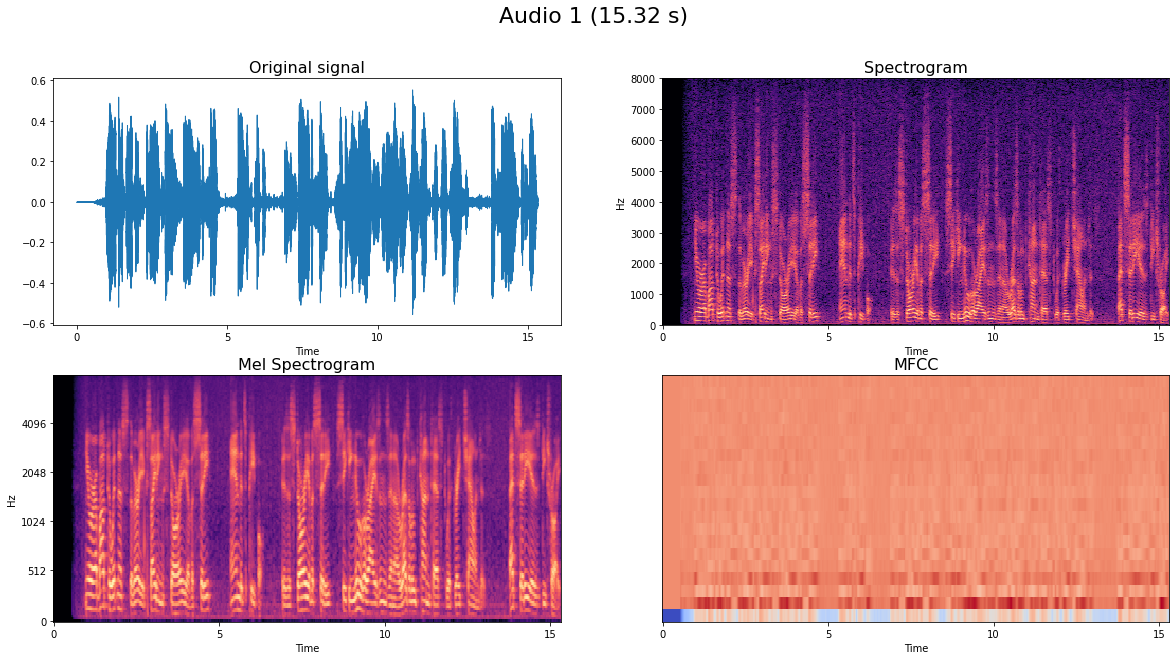

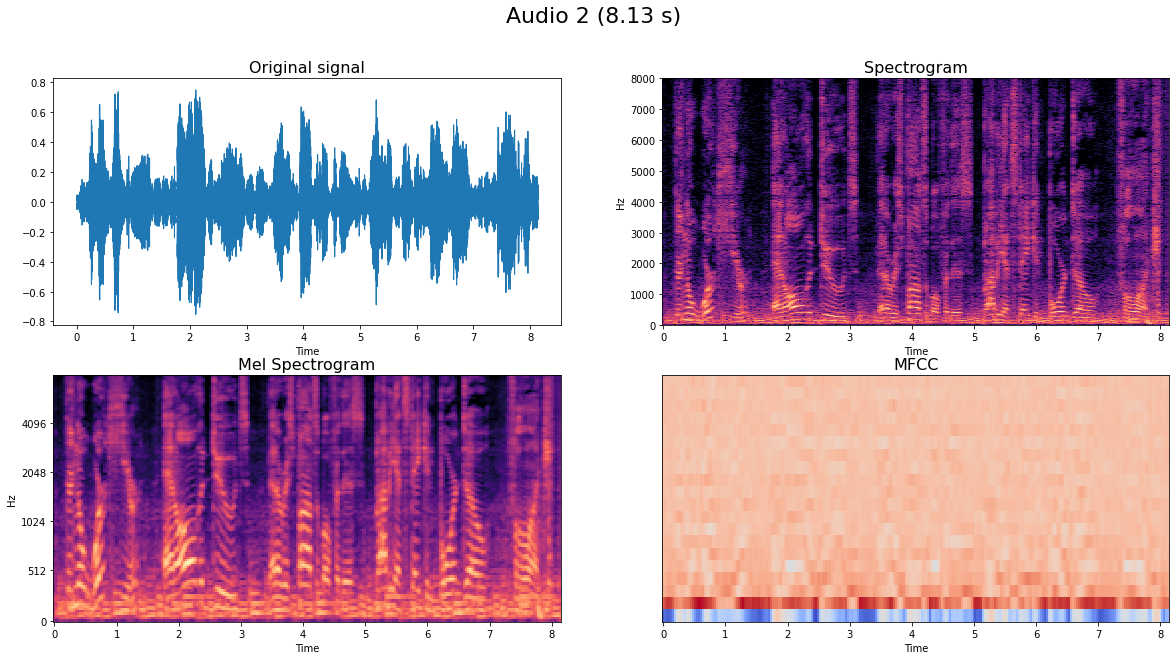

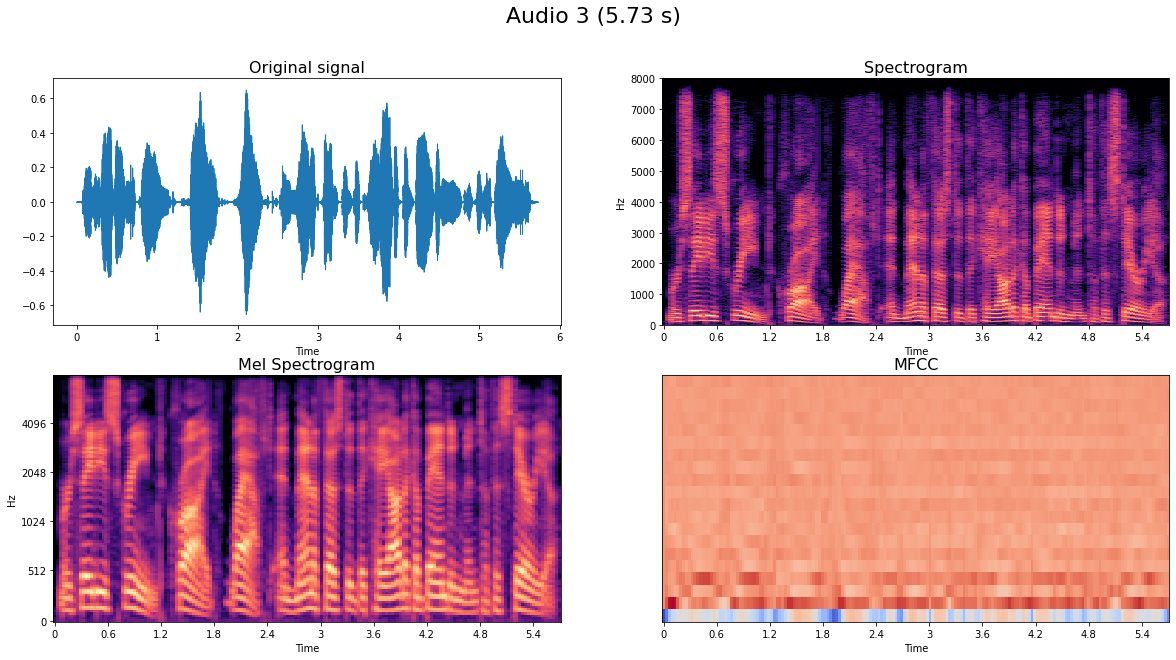

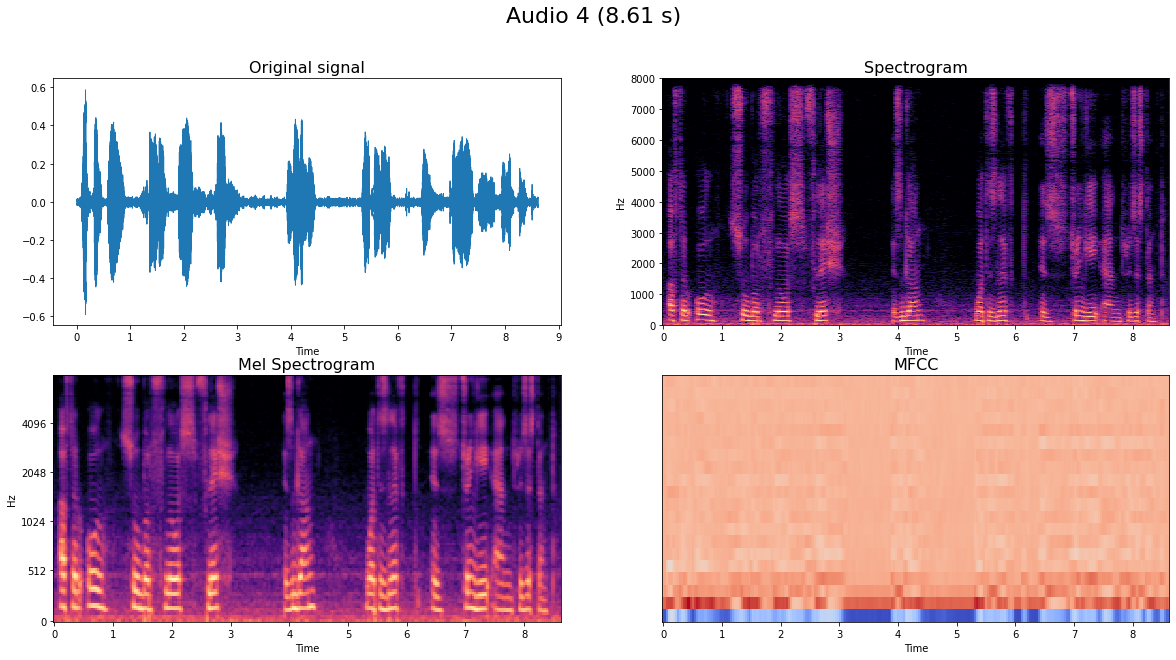

In [7]:
for i in range(files_num):
  file = f"{SPEECH_AUDIO_PATH}{i+1}.wav"
  show_audio_diagrams(file)

## Применяем аугментацию и выводим спектрограммы

In [8]:
def audio_augmentation(file_path, level=0):
  signal = read_audio(file_path)
  augmented_signal = signal.unsqueeze(0)

  noise = AddNoise(snr_low=5, snr_high=20)
  augmented_signal = noise(augmented_signal, torch.ones(1))#
  
  if level > 0:
    perturbator = SpeedPerturb(orig_freq=SAMPLE_RATE, speeds=[120])
    augmented_signal = perturbator(augmented_signal)

  if level > 1:
    drop = DropFreq(drop_freq_low=0.0005, drop_freq_high=0.008, drop_width=0.1)
    augmented_signal = drop(augmented_signal)

  plt.rcParams['figure.figsize'] = (20, 4)
  fig, ax = plt.subplots(1, 2)

  plt.suptitle(f'Augmented audio {i+1}', size=22)

  # выводим сигнал
  librosa.display.waveshow(augmented_signal.squeeze().numpy(), sr=SAMPLE_RATE, ax=ax[0])
  ax[0].title.set_text('Original signal')

  # выводим спектрограмму
  spectre = librosa.amplitude_to_db(np.abs(librosa.stft(augmented_signal.squeeze().numpy())), ref=np.max)
  librosa.display.specshow(spectre, y_axis='linear', x_axis='time', sr=SAMPLE_RATE, ax=ax[1])
  ax[1].title.set_text('Spectrogram')

  plt.show()

  # прослушивание аудио
  display(Audio(augmented_signal, rate=SAMPLE_RATE))

  return augmented_signal

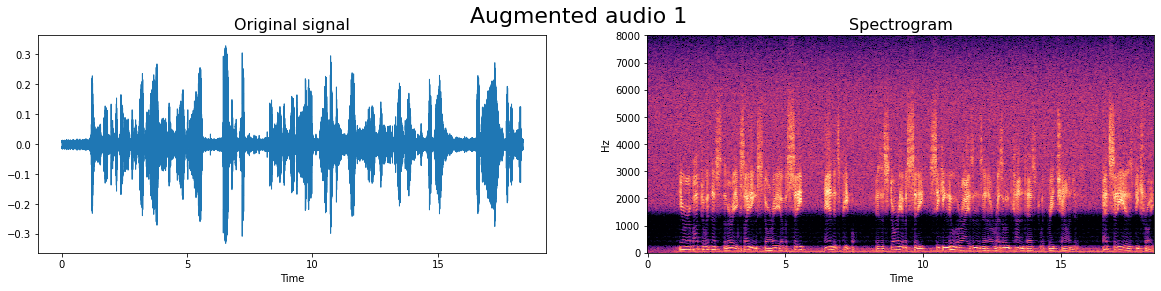

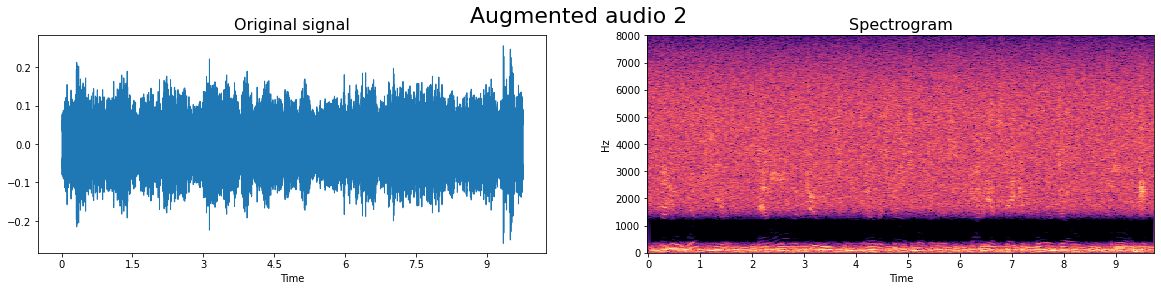

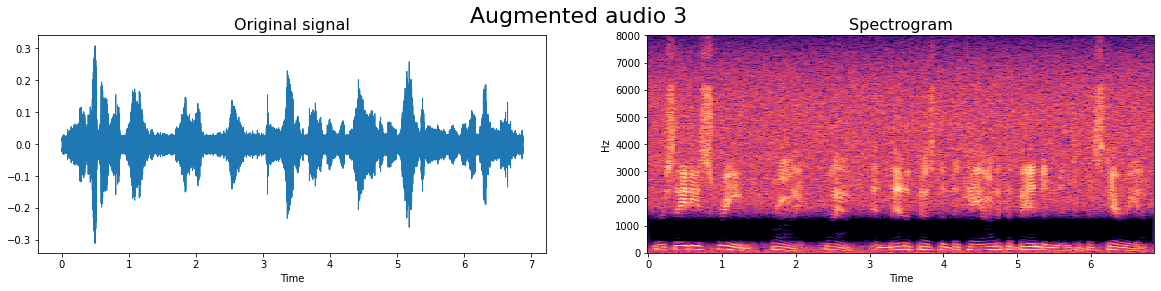

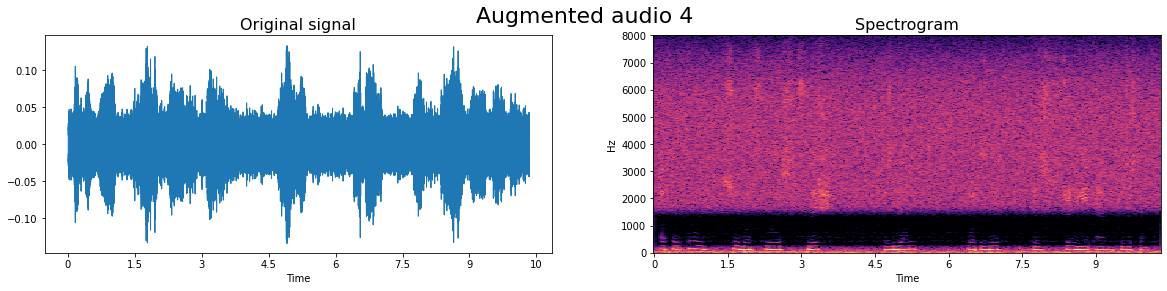

In [9]:
for i in range(files_num):
  file = f"{SPEECH_AUDIO_PATH}{i+1}.wav"
  augmented = audio_augmentation(file, 2)

  soundfile.write(f"{SPEECH_AUGMENTED_PATH}{i+1}_aug.wav", np.ravel(augmented.numpy()), SAMPLE_RATE)

## Строим пайплайн распознавания речи

### Загрузим модели NeMo

Модель **NeMo QuartzNet**

In [ ]:
model_quartz = nemo_asr.models.EncDecCTCModel.from_pretrained(model_name="QuartzNet15x5Base-En")

Модель **NeMo stt_en_conformer_transducer_large**

In [ ]:
model_conformer = nemo_asr.models.EncDecRNNTBPEModel.from_pretrained(model_name="stt_en_conformer_transducer_large")

In [12]:
NEMO_BATCH_SIZE = 16

Формируем списки текстов и аудио-файлов

In [13]:
references = []
audio_files = []
augmented_files = []

for i in range(files_num):
  # читаем текстовые файлы
  sample_text_file = f"{SPEECH_TEXT_PATH}{i+1}.txt"
  tf = open(sample_text_file)
  references.append(tf.read())
  tf.close()

  # формируем список файлов
  audio_files.append(f"{SPEECH_AUDIO_PATH}{i+1}.wav")
  augmented_files.append(f"{SPEECH_AUGMENTED_PATH}{i+1}_aug.wav")
  
references = np.array(references)

### Функция распознавания и подсчета метрики WER

In [14]:
def asr_model(model, files, references, verbose=False):
  predictions = model.transcribe(
    paths2audio_files=files,
    batch_size=NEMO_BATCH_SIZE
  )

  if (type(predictions) == tuple):
    predictions = list(predictions)[0]

  predictions = np.array(predictions)
  wer = word_error_rate(predictions, references)

  if verbose:
    print('Text:')
    print(references)
    print()
    print('Predictions:')
    print(predictions)
    print()
    print(f"WER: {round(wer, 4)}")

  return predictions, wer

## Распознаем речь в аудио-файлах

Применим модель **NeMo QuartzNet**

Выведем метрику для исходных аудио-файлов

In [15]:
predictions, wer = asr_model(model_quartz, audio_files, references, verbose=True)

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Text:
['you are about to witness the very exciting story of a city and its people it is a story of a city seeking new horizons in a resolute contest with great challenges that city is detroit'
 "there's no work here and all the dudes that are responsible for this probably had steak and bordeaux for lunch"
 'mercedes screamed cried laughed and manifested the chaotic abandonment of hysteria'
 'after all superfluous flesh is gone what is left is stringy and resistant']

Predictions:
['you are about to witness the very exciting story of a city and its people it is a story of a city seeking new horizons in a resolute contest with great challenges that city is detroit'
 "there's no work here and all the dudes that are responsible for this probably had staken boardough flunch"
 'mercedes screamed cried laughed and manifested the chaotic abandonment of hysteria'
 'after all sober floos flesh is gone what is left is stringy and resistant']

WER: 0.0875


Выведем метрику для аугментированных аудио-файлов

In [16]:
predictions, wer = asr_model(model_quartz, augmented_files, references, verbose=True)

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Text:
['you are about to witness the very exciting story of a city and its people it is a story of a city seeking new horizons in a resolute contest with great challenges that city is detroit'
 "there's no work here and all the dudes that are responsible for this probably had steak and bordeaux for lunch"
 'mercedes screamed cried laughed and manifested the chaotic abandonment of hysteria'
 'after all superfluous flesh is gone what is left is stringy and resistant']

Predictions:
['you are about to witness the very exciting story of a city and its people it is e story of a city seeking new horizons in a resolute contest with great challenges that city is detroit'
 'too ter dav awer junto tear responsible for this garbiat taken toor dole an tewar'
 'mercevis screamed fried laughed and manifested the chaotic abandonment tof hysteria'
 'after all she was most smish gan watblue and stringly ermet in the stan']

WER: 0.4125


Применим модель **NeMo stt_en_conformer_transducer_large**

Выведем метрику для исходных аудио-файлов

In [17]:
predictions, wer = asr_model(model_conformer, audio_files, references, verbose=True)

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Text:
['you are about to witness the very exciting story of a city and its people it is a story of a city seeking new horizons in a resolute contest with great challenges that city is detroit'
 "there's no work here and all the dudes that are responsible for this probably had steak and bordeaux for lunch"
 'mercedes screamed cried laughed and manifested the chaotic abandonment of hysteria'
 'after all superfluous flesh is gone what is left is stringy and resistant']

Predictions:
['are about to witness the very exciting story of a city and its people it is a story of a city seeking new horizons in a resolute contest with great challenges that city is detroit'
 "there's no work here and all the dudes that are responsible for this probably at stake in bordeaux for lunch"
 'mercedes screamed cried laughed and manifested the chaotic abandonment of hysteria'
 'after all superfluous flesh is gone what is left is stringy and resistant']

WER: 0.05


Выведем метрику для аугментированных аудио-файлов

In [18]:
predictions, wer = asr_model(model_conformer, augmented_files, references, verbose=True)

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Text:
['you are about to witness the very exciting story of a city and its people it is a story of a city seeking new horizons in a resolute contest with great challenges that city is detroit'
 "there's no work here and all the dudes that are responsible for this probably had steak and bordeaux for lunch"
 'mercedes screamed cried laughed and manifested the chaotic abandonment of hysteria'
 'after all superfluous flesh is gone what is left is stringy and resistant']

Predictions:
['you are about to witness the very exciting story of a city of a city seeking new rises in a resolute contest with great challenge detroit'
 '' 'mercedes scream cry and manifested the chaotic abandonment hysteria'
 'after all she bought laws flesh is done what is left is stringy and resistant']

WER: 0.5
